<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
CROPPING = False
SEGMENTATION = False
CLAHE = False

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

  !kaggle datasets download -d "tschandl/ham10000-lesion-segmentations"

  !unzip -o ham10000-lesion-segmentations.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [89]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [90]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setmasks__(self,masks):
      self.masks = masks

  def __getmask__(self,i):
      return self.masks[i]

  def __lenmasks__(self):
    return len(self.masks)

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if SEGMENTATION:
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        _, mask_binaria = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        image = cv2.bitwise_and(image, image, mask=mask_binaria)

        non_black_pixels = np.where(image > 0)

        x_min, x_max = np.min(non_black_pixels[1]), np.max(non_black_pixels[1])
        y_min, y_max = np.min(non_black_pixels[0]), np.max(non_black_pixels[0])

        marge = 10
        if ((x_min - marge) >= 0):
            x_min = x_min - marge
        if ((x_max + marge) <= 224):
            x_max = x_max + marge

        if CROPPING:
          image = image[y_min:y_max, x_min:x_max]

        # print(cropped_image.shape)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)




      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [91]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [92]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)

  mask_files = sorted(glob('/content/sample_data/HAM10000_segmentations_lesion_tschandl/*'))

  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  mask_path_dict = {os.path.splitext(os.path.basename(x))[0].replace('_segmentation', ''): x for x in mask_files}

  #print(mask_path_dict)

  #{'ISIC_0024306_segmentation': '/content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png'

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['mask_path'] = metadates['image_id'].map(mask_path_dict.get)

  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)

  if SEGMENTATION:

    train_data.__setmasks__(X_train['mask_path'].to_numpy())
    test_data.__setmasks__(X_test['mask_path'].to_numpy())
    validation_data.__setmasks__(X_val['mask_path'].to_numpy())

  return train_data, validation_data,test_data


In [93]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

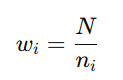

In [94]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [95]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [96]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [97]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [98]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [99]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [100]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [101]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)

    clean_img = cv2.resize(clean_img, (224, 224))
    clean_img = torch.tensor(clean_img).permute(2, 0, 1)  # Convert to (C, H, W)

    print(clean_img.shape)

    imatge,label = train_data.__getitem__(i)
    print(imatge.shape)
    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [102]:
from itertools import product
BINARY = False #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
img_sizes = {'alexnet': 224,'resnet152':224,'inceptionv3':299,'efficientnetb1':224,'alexnetmulticlass':224,'resnet152multiclass':224,'inceptionv3multiclass':299,'efficientnetb1multiclass':224}

nom_model = 'inceptionv3multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = img_sizes[nom_model]


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None

if SEGMENTATION == False:
  transform = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])

CLAHE = False
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)


parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "SEGMENTATION": SEGMENTATION,
                "CROPPING": CROPPING,
                "img_size": SIZE,
                "random_state": 42,
                "WeightsAndBiases": wandb.run.get_url(),
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': False}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.847307944202803
Accuracy train epoch: 1  train_acc: 0.2677698297718218
F1 train epoch: 1  train_f1: 0.3153788155530835
Recall train epoch: 1  train_recall: 0.2677698297718218


Pèrdua validació epoch: 1  val_loss: 1.71230723336339
Accuracy val epoch: 1  val_acc: 0.4734375
F1 val epoch: 1  val_f1: 0.5391151964913719
Recall val epoch: 1  val_recall: 0.4734375
Recall val epoch: 1  val_precision: 0.7519863112148267


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 1.5157596502171096
Accuracy train epoch: 2  train_acc: 0.5209955632017386
F1 train epoch: 2  train_f1: 0.5874231829652508
Recall train epoch: 2  train_recall: 0.5209955632017386


Pèrdua validació epoch: 2  val_loss: 1.4012733213603497
Accuracy val epoch: 2  val_acc: 0.575390625
F1 val epoch: 2  val_f1: 0.632601882176502
Recall val epoch: 2  val_recall: 0.575390625
Recall val epoch: 2  val_precision: 0.7840136721778783


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 1.2241441571854974
Accuracy train epoch: 3  train_acc: 0.6198275081492213
F1 train epoch: 3  train_f1: 0.6751264203183017
Recall train epoch: 3  train_recall: 0.6198275081492213


Pèrdua validació epoch: 3  val_loss: 1.152988750487566
Accuracy val epoch: 3  val_acc: 0.663671875
F1 val epoch: 3  val_f1: 0.7067088939909937
Recall val epoch: 3  val_recall: 0.663671875
Recall val epoch: 3  val_precision: 0.8078362481371759


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.9799655948977072
Accuracy train epoch: 4  train_acc: 0.6662554328141977
F1 train epoch: 4  train_f1: 0.7150302300875535
Recall train epoch: 4  train_recall: 0.6662554328141977


Pèrdua validació epoch: 4  val_loss: 0.9543474325910211
Accuracy val epoch: 4  val_acc: 0.6705078125
F1 val epoch: 4  val_f1: 0.7123064561097153
Recall val epoch: 4  val_recall: 0.6705078125
Recall val epoch: 4  val_precision: 0.8110368585812044


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.8312214211638705
Accuracy train epoch: 5  train_acc: 0.6942570626584571
F1 train epoch: 5  train_f1: 0.7397460689391723
Recall train epoch: 5  train_recall: 0.6942570626584571


Pèrdua validació epoch: 5  val_loss: 0.8260215651243925
Accuracy val epoch: 5  val_acc: 0.7037109375
F1 val epoch: 5  val_f1: 0.7420668361246807
Recall val epoch: 5  val_recall: 0.7037109375
Recall val epoch: 5  val_precision: 0.836692574930968


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.7090941905025467
Accuracy train epoch: 6  train_acc: 0.7225416515755161
F1 train epoch: 6  train_f1: 0.7629867312676288
Recall train epoch: 6  train_recall: 0.7225416515755161


Pèrdua validació epoch: 6  val_loss: 0.8012601649388671
Accuracy val epoch: 6  val_acc: 0.7099609375
F1 val epoch: 6  val_f1: 0.7456175779927381
Recall val epoch: 6  val_recall: 0.7099609375
Recall val epoch: 6  val_precision: 0.833162708442752


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.6261852302280555
Accuracy train epoch: 7  train_acc: 0.7517769829771821
F1 train epoch: 7  train_f1: 0.787687201320821
Recall train epoch: 7  train_recall: 0.7517769829771821


Pèrdua validació epoch: 7  val_loss: 0.7266002437099814
Accuracy val epoch: 7  val_acc: 0.7392578125
F1 val epoch: 7  val_f1: 0.7682068729510364
Recall val epoch: 7  val_recall: 0.7392578125
Recall val epoch: 7  val_precision: 0.8416354595223506


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.5471207312497485
Accuracy train epoch: 8  train_acc: 0.760729808040565
F1 train epoch: 8  train_f1: 0.793387345579511
Recall train epoch: 8  train_recall: 0.760729808040565


Pèrdua validació epoch: 8  val_loss: 0.6739089391194284
Accuracy val epoch: 8  val_acc: 0.76171875
F1 val epoch: 8  val_f1: 0.7884064615721071
Recall val epoch: 8  val_recall: 0.76171875
Recall val epoch: 8  val_precision: 0.8567931403277826


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.5051288604142656
Accuracy train epoch: 9  train_acc: 0.7745721658819268
F1 train epoch: 9  train_f1: 0.8054376646465672
Recall train epoch: 9  train_recall: 0.7745721658819268


Pèrdua validació epoch: 9  val_loss: 0.652921593748033
Accuracy val epoch: 9  val_acc: 0.758984375
F1 val epoch: 9  val_f1: 0.7848254390111662
Recall val epoch: 9  val_recall: 0.758984375
Recall val epoch: 9  val_precision: 0.8525820584855688


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.4511642467334451
Accuracy train epoch: 10  train_acc: 0.7877580586743933
F1 train epoch: 10  train_f1: 0.8165623476871572
Recall train epoch: 10  train_recall: 0.7877580586743933


Pèrdua validació epoch: 10  val_loss: 0.6033862610347569
Accuracy val epoch: 10  val_acc: 0.7685546875
F1 val epoch: 10  val_f1: 0.7954009164042503
Recall val epoch: 10  val_recall: 0.7685546875
Recall val epoch: 10  val_precision: 0.863816574012355


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.4147052750941292
Accuracy train epoch: 11  train_acc: 0.8035698116624411
F1 train epoch: 11  train_f1: 0.83142177729318
Recall train epoch: 11  train_recall: 0.8035698116624411


Pèrdua validació epoch: 11  val_loss: 0.6015713680535555
Accuracy val epoch: 11  val_acc: 0.7658203125
F1 val epoch: 11  val_f1: 0.7922078248336193
Recall val epoch: 11  val_recall: 0.7658203125
Recall val epoch: 11  val_precision: 0.8577521191531462


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.39019851621047436
Accuracy train epoch: 12  train_acc: 0.8071690510684535
F1 train epoch: 12  train_f1: 0.8352590152373671
Recall train epoch: 12  train_recall: 0.8071690510684535


Pèrdua validació epoch: 12  val_loss: 0.6000312785618007
Accuracy val epoch: 12  val_acc: 0.7888671875
F1 val epoch: 12  val_f1: 0.8064659367351229
Recall val epoch: 12  val_recall: 0.7888671875
Recall val epoch: 12  val_precision: 0.8559421825367389


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3420573136661632
Accuracy train epoch: 13  train_acc: 0.8226072980804057
F1 train epoch: 13  train_f1: 0.8460595232677616
Recall train epoch: 13  train_recall: 0.8226072980804057


Pèrdua validació epoch: 13  val_loss: 0.5979873437900096
Accuracy val epoch: 13  val_acc: 0.787109375
F1 val epoch: 13  val_f1: 0.8067648010384748
Recall val epoch: 13  val_recall: 0.787109375
Recall val epoch: 13  val_precision: 0.8640388205473979


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.3257010189957353
Accuracy train epoch: 14  train_acc: 0.8302132379572619
F1 train epoch: 14  train_f1: 0.853709838875624
Recall train epoch: 14  train_recall: 0.8302132379572619


Pèrdua validació epoch: 14  val_loss: 0.5725412690080702
Accuracy val epoch: 14  val_acc: 0.78203125
F1 val epoch: 14  val_f1: 0.8050377248765456
Recall val epoch: 14  val_recall: 0.78203125
Recall val epoch: 14  val_precision: 0.8682076108531654


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.29933948161829993
Accuracy train epoch: 15  train_acc: 0.8380342267294458
F1 train epoch: 15  train_f1: 0.8605785676608657
Recall train epoch: 15  train_recall: 0.8380342267294458


Pèrdua validació epoch: 15  val_loss: 0.5824760738760233
Accuracy val epoch: 15  val_acc: 0.7796875
F1 val epoch: 15  val_f1: 0.795793295893744
Recall val epoch: 15  val_recall: 0.7796875
Recall val epoch: 15  val_precision: 0.8523503660238662


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.2855343666536162
Accuracy train epoch: 16  train_acc: 0.846624864179645
F1 train epoch: 16  train_f1: 0.8682639747811854
Recall train epoch: 16  train_recall: 0.846624864179645


Pèrdua validació epoch: 16  val_loss: 0.606760632712394
Accuracy val epoch: 16  val_acc: 0.78359375
F1 val epoch: 16  val_f1: 0.8088626005725726
Recall val epoch: 16  val_recall: 0.78359375
Recall val epoch: 16  val_precision: 0.8649383791031462


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.2559460769463108
Accuracy train epoch: 17  train_acc: 0.8539818000724375
F1 train epoch: 17  train_f1: 0.8733181700548058
Recall train epoch: 17  train_recall: 0.8539818000724375


Pèrdua validació epoch: 17  val_loss: 0.6120597468689084
Accuracy val epoch: 17  val_acc: 0.79765625
F1 val epoch: 17  val_f1: 0.8137610364488818
Recall val epoch: 17  val_recall: 0.79765625
Recall val epoch: 17  val_precision: 0.8606976455516675


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.24627591133770715
Accuracy train epoch: 18  train_acc: 0.8589505613908004
F1 train epoch: 18  train_f1: 0.8774457862164265
Recall train epoch: 18  train_recall: 0.8589505613908004


Pèrdua validació epoch: 18  val_loss: 0.6025528577156365
Accuracy val epoch: 18  val_acc: 0.8021484375
F1 val epoch: 18  val_f1: 0.8203387373550208
Recall val epoch: 18  val_recall: 0.8021484375
Recall val epoch: 18  val_precision: 0.8736071564223838


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.227380082144799
Accuracy train epoch: 19  train_acc: 0.8684353495110467
F1 train epoch: 19  train_f1: 0.8865568975041244
Recall train epoch: 19  train_recall: 0.8684353495110467


Pèrdua validació epoch: 19  val_loss: 0.5586493028094992
Accuracy val epoch: 19  val_acc: 0.8251953125
F1 val epoch: 19  val_f1: 0.8375038834986861
Recall val epoch: 19  val_recall: 0.8251953125
Recall val epoch: 19  val_precision: 0.8842651864642201


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.21848883576305264
Accuracy train epoch: 20  train_acc: 0.875882832307135
F1 train epoch: 20  train_f1: 0.8921721489751488
Recall train epoch: 20  train_recall: 0.875882832307135


Pèrdua validació epoch: 20  val_loss: 0.5957468897104263
Accuracy val epoch: 20  val_acc: 0.826171875
F1 val epoch: 20  val_f1: 0.8397864866432531
Recall val epoch: 20  val_recall: 0.826171875
Recall val epoch: 20  val_precision: 0.877907905155753


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.1880809628141235
Accuracy train epoch: 21  train_acc: 0.8836359109018471
F1 train epoch: 21  train_f1: 0.8989539793743044
Recall train epoch: 21  train_recall: 0.8836359109018471


Pèrdua validació epoch: 21  val_loss: 0.5809902367182076
Accuracy val epoch: 21  val_acc: 0.82578125
F1 val epoch: 21  val_f1: 0.8350829855400038
Recall val epoch: 21  val_recall: 0.82578125
Recall val epoch: 21  val_precision: 0.8743607260776523


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.17265500058512764
Accuracy train epoch: 22  train_acc: 0.8962898406374502
F1 train epoch: 22  train_f1: 0.910261633789955
Recall train epoch: 22  train_recall: 0.8962898406374502


Pèrdua validació epoch: 22  val_loss: 0.6719364454038441
Accuracy val epoch: 22  val_acc: 0.823828125
F1 val epoch: 22  val_f1: 0.8368233238403742
Recall val epoch: 22  val_recall: 0.823828125
Recall val epoch: 22  val_precision: 0.8850966840006209


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.16427659362079614
Accuracy train epoch: 23  train_acc: 0.9010209163346613
F1 train epoch: 23  train_f1: 0.9135983101903524
Recall train epoch: 23  train_recall: 0.9010209163346613


Pèrdua validació epoch: 23  val_loss: 0.6691957688890398
Accuracy val epoch: 23  val_acc: 0.816015625
F1 val epoch: 23  val_f1: 0.8308412902987644
Recall val epoch: 23  val_recall: 0.816015625
Recall val epoch: 23  val_precision: 0.8762796601602365


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.15153222033138056
Accuracy train epoch: 24  train_acc: 0.9024017566099239
F1 train epoch: 24  train_f1: 0.9154127802371008
Recall train epoch: 24  train_recall: 0.9024017566099239


Pèrdua validació epoch: 24  val_loss: 0.6212379820644855
Accuracy val epoch: 24  val_acc: 0.8333984375
F1 val epoch: 24  val_f1: 0.8433468406182361
Recall val epoch: 24  val_recall: 0.8333984375
Recall val epoch: 24  val_precision: 0.8859839132230624


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.1474719843808636
Accuracy train epoch: 25  train_acc: 0.9022772546178921
F1 train epoch: 25  train_f1: 0.9165348622936202
Recall train epoch: 25  train_recall: 0.9022772546178921


Pèrdua validació epoch: 25  val_loss: 0.6657277725171298
Accuracy val epoch: 25  val_acc: 0.8263671875
F1 val epoch: 25  val_f1: 0.8343255615612301
Recall val epoch: 25  val_recall: 0.8263671875
Recall val epoch: 25  val_precision: 0.8697541829948436


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.14839277711077278
Accuracy train epoch: 26  train_acc: 0.9092606845345889
F1 train epoch: 26  train_f1: 0.9213158479184362
Recall train epoch: 26  train_recall: 0.9092606845345889


Pèrdua validació epoch: 26  val_loss: 0.646417195443064
Accuracy val epoch: 26  val_acc: 0.838671875
F1 val epoch: 26  val_f1: 0.8508606983011866
Recall val epoch: 26  val_recall: 0.838671875
Recall val epoch: 26  val_precision: 0.8925702267761128


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.14357460776262312
Accuracy train epoch: 27  train_acc: 0.914987776168055
F1 train epoch: 27  train_f1: 0.9261541720791704
Recall train epoch: 27  train_recall: 0.914987776168055


Pèrdua validació epoch: 27  val_loss: 0.6586532949004322
Accuracy val epoch: 27  val_acc: 0.835546875
F1 val epoch: 27  val_f1: 0.8450265390911221
Recall val epoch: 27  val_recall: 0.835546875
Recall val epoch: 27  val_precision: 0.8894866892576737


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.13284807148356123
Accuracy train epoch: 28  train_acc: 0.9234425932633104
F1 train epoch: 28  train_f1: 0.932725904481582
Recall train epoch: 28  train_recall: 0.9234425932633104


Pèrdua validació epoch: 28  val_loss: 0.6856763591058552
Accuracy val epoch: 28  val_acc: 0.8505859375
F1 val epoch: 28  val_f1: 0.8653672133838216
Recall val epoch: 28  val_recall: 0.8505859375
Recall val epoch: 28  val_precision: 0.906548824800997


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.1212098666826686
Accuracy train epoch: 29  train_acc: 0.9263061390800434
F1 train epoch: 29  train_f1: 0.9372711905755008
Recall train epoch: 29  train_recall: 0.9263061390800434


Pèrdua validació epoch: 29  val_loss: 0.72297996818088
Accuracy val epoch: 29  val_acc: 0.8375
F1 val epoch: 29  val_f1: 0.8439406053793842
Recall val epoch: 29  val_recall: 0.8375
Recall val epoch: 29  val_precision: 0.8819382002765077


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.11166927276691237
Accuracy train epoch: 30  train_acc: 0.9321577327055415
F1 train epoch: 30  train_f1: 0.94206612818865
Recall train epoch: 30  train_recall: 0.9321577327055415


Pèrdua validació epoch: 30  val_loss: 0.6699170684441924
Accuracy val epoch: 30  val_acc: 0.8486328125
F1 val epoch: 30  val_f1: 0.8545567079157144
Recall val epoch: 30  val_recall: 0.8486328125
Recall val epoch: 30  val_precision: 0.8906834949622131


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.10710823968743008
Accuracy train epoch: 31  train_acc: 0.9320219123505976
F1 train epoch: 31  train_f1: 0.9408998273669764
Recall train epoch: 31  train_recall: 0.9320219123505976


Pèrdua validació epoch: 31  val_loss: 0.6901149110053666
Accuracy val epoch: 31  val_acc: 0.8537109375
F1 val epoch: 31  val_f1: 0.8612757892578826
Recall val epoch: 31  val_recall: 0.8537109375
Recall val epoch: 31  val_precision: 0.8992121448036225


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.10476271497582891
Accuracy train epoch: 32  train_acc: 0.9412350597609562
F1 train epoch: 32  train_f1: 0.9500802537944548
Recall train epoch: 32  train_recall: 0.9412350597609562


Pèrdua validació epoch: 32  val_loss: 0.7458834184799343
Accuracy val epoch: 32  val_acc: 0.8568359375
F1 val epoch: 32  val_f1: 0.8600123814686197
Recall val epoch: 32  val_recall: 0.8568359375
Recall val epoch: 32  val_precision: 0.895161304766825


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.09825643366091398
Accuracy train epoch: 33  train_acc: 0.9373981347337921
F1 train epoch: 33  train_f1: 0.9459713163698915
Recall train epoch: 33  train_recall: 0.9373981347337921


Pèrdua validació epoch: 33  val_loss: 0.7466337196528912
Accuracy val epoch: 33  val_acc: 0.8599609375
F1 val epoch: 33  val_f1: 0.8603253168753485
Recall val epoch: 33  val_recall: 0.8599609375
Recall val epoch: 33  val_precision: 0.8905266282747288


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.10182523340417213
Accuracy train epoch: 34  train_acc: 0.9483543100325968
F1 train epoch: 34  train_f1: 0.9554195059158248
Recall train epoch: 34  train_recall: 0.9483543100325968


Pèrdua validació epoch: 34  val_loss: 0.7397563350386918
Accuracy val epoch: 34  val_acc: 0.862109375
F1 val epoch: 34  val_f1: 0.8633506452529125
Recall val epoch: 34  val_recall: 0.862109375
Recall val epoch: 34  val_precision: 0.8985619687097045


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.08870514225496715
Accuracy train epoch: 35  train_acc: 0.9454794458529518
F1 train epoch: 35  train_f1: 0.9528821277254745
Recall train epoch: 35  train_recall: 0.9454794458529518


Pèrdua validació epoch: 35  val_loss: 0.7037355450447649
Accuracy val epoch: 35  val_acc: 0.8767578125
F1 val epoch: 35  val_f1: 0.8788784790542746
Recall val epoch: 35  val_recall: 0.8767578125
Recall val epoch: 35  val_precision: 0.9090805399140334


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.08378306804670102
Accuracy train epoch: 36  train_acc: 0.9468489677653024
F1 train epoch: 36  train_f1: 0.9538603562476922
Recall train epoch: 36  train_recall: 0.9468489677653024


Pèrdua validació epoch: 36  val_loss: 0.6967102170456201
Accuracy val epoch: 36  val_acc: 0.8650390625
F1 val epoch: 36  val_f1: 0.8676135206480223
Recall val epoch: 36  val_recall: 0.8650390625
Recall val epoch: 36  val_precision: 0.9023608399729556


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.0765645689297601
Accuracy train epoch: 37  train_acc: 0.9523157370517928
F1 train epoch: 37  train_f1: 0.9586775423648369
Recall train epoch: 37  train_recall: 0.9523157370517928


Pèrdua validació epoch: 37  val_loss: 0.7032086091057863
Accuracy val epoch: 37  val_acc: 0.8689453125
F1 val epoch: 37  val_f1: 0.8719780954184947
Recall val epoch: 37  val_recall: 0.8689453125
Recall val epoch: 37  val_precision: 0.8952336805349177


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.06622563658163426
Accuracy train epoch: 38  train_acc: 0.9553037848605578
F1 train epoch: 38  train_f1: 0.9612304397138313
Recall train epoch: 38  train_recall: 0.9553037848605578


Pèrdua validació epoch: 38  val_loss: 0.722406264860183
Accuracy val epoch: 38  val_acc: 0.8669921875
F1 val epoch: 38  val_f1: 0.8719414975712044
Recall val epoch: 38  val_recall: 0.8669921875
Recall val epoch: 38  val_precision: 0.9010036619876435


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.0656532165594399
Accuracy train epoch: 39  train_acc: 0.9556886091995653
F1 train epoch: 39  train_f1: 0.9619257708955167
Recall train epoch: 39  train_recall: 0.9556886091995653


Pèrdua validació epoch: 39  val_loss: 0.7487189094536006
Accuracy val epoch: 39  val_acc: 0.8759765625
F1 val epoch: 39  val_f1: 0.8788620988412761
Recall val epoch: 39  val_recall: 0.8759765625
Recall val epoch: 39  val_precision: 0.9087384071314704


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.07400346962193331
Accuracy train epoch: 40  train_acc: 0.9605328685258964
F1 train epoch: 40  train_f1: 0.9662226877056602
Recall train epoch: 40  train_recall: 0.9605328685258964


Pèrdua validació epoch: 40  val_loss: 0.7839951659552753
Accuracy val epoch: 40  val_acc: 0.8650390625
F1 val epoch: 40  val_f1: 0.8631974426333333
Recall val epoch: 40  val_recall: 0.8650390625
Recall val epoch: 40  val_precision: 0.8963458625411851


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.07396823142198809
Accuracy train epoch: 41  train_acc: 0.9601593625498008
F1 train epoch: 41  train_f1: 0.9658692596335813
Recall train epoch: 41  train_recall: 0.9601593625498008


Pèrdua validació epoch: 41  val_loss: 0.689014753093943
Accuracy val epoch: 41  val_acc: 0.8669921875
F1 val epoch: 41  val_f1: 0.8671618474074797
Recall val epoch: 41  val_recall: 0.8669921875
Recall val epoch: 41  val_precision: 0.8916045277056356


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.0692173352212723
Accuracy train epoch: 42  train_acc: 0.9636454183266933
F1 train epoch: 42  train_f1: 0.9692584141609745
Recall train epoch: 42  train_recall: 0.9636454183266933


Pèrdua validació epoch: 42  val_loss: 0.7945378171862103
Accuracy val epoch: 42  val_acc: 0.8646484375
F1 val epoch: 42  val_f1: 0.8578622815413008
Recall val epoch: 42  val_recall: 0.8646484375
Recall val epoch: 42  val_precision: 0.8851714197145654


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.05612869716742896
Accuracy train epoch: 43  train_acc: 0.9657619521912351
F1 train epoch: 43  train_f1: 0.9706210710306343
Recall train epoch: 43  train_recall: 0.9657619521912351


Pèrdua validació epoch: 43  val_loss: 0.8025065108668059
Accuracy val epoch: 43  val_acc: 0.8689453125
F1 val epoch: 43  val_f1: 0.8663251288256121
Recall val epoch: 43  val_recall: 0.8689453125
Recall val epoch: 43  val_precision: 0.8855482677286043


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.060108696636502666
Accuracy train epoch: 44  train_acc: 0.9682519920318725
F1 train epoch: 44  train_f1: 0.972777812005116
Recall train epoch: 44  train_recall: 0.9682519920318725


Pèrdua validació epoch: 44  val_loss: 0.7799750365084037
Accuracy val epoch: 44  val_acc: 0.862109375
F1 val epoch: 44  val_f1: 0.8619530710417648
Recall val epoch: 44  val_recall: 0.862109375
Recall val epoch: 44  val_precision: 0.8908466110404573


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.05396956170675348
Accuracy train epoch: 45  train_acc: 0.9666447844983701
F1 train epoch: 45  train_f1: 0.9716209793083909
Recall train epoch: 45  train_recall: 0.9666447844983701


Pèrdua validació epoch: 45  val_loss: 0.8024853731039912
Accuracy val epoch: 45  val_acc: 0.8685546875
F1 val epoch: 45  val_f1: 0.8679118194454699
Recall val epoch: 45  val_recall: 0.8685546875
Recall val epoch: 45  val_precision: 0.9037274646566962


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.051719999143044905
Accuracy train epoch: 46  train_acc: 0.9694970119521913
F1 train epoch: 46  train_f1: 0.9736576815655699
Recall train epoch: 46  train_recall: 0.9694970119521913


Pèrdua validació epoch: 46  val_loss: 0.8399762571789324
Accuracy val epoch: 46  val_acc: 0.8669921875
F1 val epoch: 46  val_f1: 0.8701387669944716
Recall val epoch: 46  val_recall: 0.8669921875
Recall val epoch: 46  val_precision: 0.9036682725268788


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.05397380490887509
Accuracy train epoch: 47  train_acc: 0.9727567004708438
F1 train epoch: 47  train_f1: 0.9763139278747225
Recall train epoch: 47  train_recall: 0.9727567004708438


Pèrdua validació epoch: 47  val_loss: 0.7277496424503624
Accuracy val epoch: 47  val_acc: 0.8828125
F1 val epoch: 47  val_f1: 0.879499199222127
Recall val epoch: 47  val_recall: 0.8828125
Recall val epoch: 47  val_precision: 0.9029035433902874


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.05863188761861557
Accuracy train epoch: 48  train_acc: 0.9672559760956175
F1 train epoch: 48  train_f1: 0.9718255304315847
Recall train epoch: 48  train_recall: 0.9672559760956175


Pèrdua validació epoch: 48  val_loss: 0.6425974254962057
Accuracy val epoch: 48  val_acc: 0.863671875
F1 val epoch: 48  val_f1: 0.8660168515521189
Recall val epoch: 48  val_recall: 0.863671875
Recall val epoch: 48  val_precision: 0.8964849219768559


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.05306763644979532
Accuracy train epoch: 49  train_acc: 0.9698818362911988
F1 train epoch: 49  train_f1: 0.9749159383579539
Recall train epoch: 49  train_recall: 0.9698818362911988


Pèrdua validació epoch: 49  val_loss: 0.7676128651946783
Accuracy val epoch: 49  val_acc: 0.871875
F1 val epoch: 49  val_f1: 0.873782493157274
Recall val epoch: 49  val_recall: 0.871875
Recall val epoch: 49  val_precision: 0.8977072264290745


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.04622542351090991
Accuracy train epoch: 50  train_acc: 0.9721115537848606
F1 train epoch: 50  train_f1: 0.9767735264894434
Recall train epoch: 50  train_recall: 0.9721115537848606


Pèrdua validació epoch: 50  val_loss: 0.8312908370862715
Accuracy val epoch: 50  val_acc: 0.8734375
F1 val epoch: 50  val_f1: 0.8746582486417245
Recall val epoch: 50  val_recall: 0.8734375
Recall val epoch: 50  val_precision: 0.9097258783102361
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


train/train_acc,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train/train_f1,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
train/train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
train/train_recall,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
val/val_acc,▁▃▄▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
val/val_f1,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███████████████
val/val_loss,█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃
val/val_precision,▁▂▃▄▅▅▆▅▆▆▆▅▆▆▆▇▆▇▇▇▇▇█▇▇▇▇█████▇▇▇▇██▇█
val/val_recall,▁▃▄▄▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
train/train_acc,0.97211


In [103]:
# print(validation_data.__getmask__(3))
# print(validation_data.__getpath__(3))
# print(validation_data.__len__())
# print(validation_data.__lenmasks__())